![alt text](img/LM.png)
# Kurs: Deep Learning, Text Mining i XAI w Pythonie

## Autor: Piotr Ćwiakowski

### Lekcja 6. Wprowadzenie do Natural Language Processing w Pythonie

#### Spis treści

1. Wprowadzenie
2. Pakiety do NLP w Pythonie
3. Wczytywanie danych 
4. Czyszczenie korpusu
5. Tworzenie Document Term Matrix
6. Podstawowy feature engineering w Text Miningu.
7. Podstawowe techniki wizualizacji danych.
8. Inne operacje na tekstach.

# 1 Wprowadzenie

Rozwój narzędzi analitycznych i wzrost mocy obliczeniowej komputerów otworzył możliwości ilościowego analizowania języka naturalnego - pisanego, a w ostatnich latach (dekadach) również mówionego. Dotyczy to zarówno krótkich wypowiedzi (komentarze w mediach społecznościowych) jak i długich: artykuły, raporty, recenzje, książki. W odróżnieniu od analizy klasycznych danych tabelarycznych przetwarzanie języka naturalnego zależy silnie od kontekstów: językowego (każdy język ma swoją specyfikę, trudności i ułatwienia - przykładowo język angielski jest łatwiejszy do analizowania od polskiego, ponieważ jest zwyczajnie prostszy), tematycznego (nieco inne podejście i problemy wystąpią przy analizie dokumentów urzędowych, a inne przy analizie spontanicznych wypowiedzi na Facebooku) i kulturowo-społecznego.

<img src="img/tm1.png" width="70%">
Źródło: Kwartler, Ted. "Text Mining in Practice with R." (2017).

Wykorzystanie języka naturalnego w analizach ilościowych można podzielić na dwie główne fazy:

1. Oczyszczenie i standaryzacja tekstu oraz stworzenie z nieustrukturyzowanego korpusu (zbioru pojedynczych tekstów, obserwacji) danych tabelarycznych (tzw. Document Term Matrix),  
2. Wykorzystanie stworzonej tablicy z danymi numerycznymi w modelach ML.

<img src="img/tm2.png" width="40%">
Źródło: https://stackoverflow.com/questions/38712750/how-could-i-make-document-term-matrix-with-my-own-term-list

W toku wykonywania obydwu kroków zwykle natrafiamy na następujące problemy:
* przetworzenie posiadanego zbioru wymaga dużych mocy obliczeniowych i zasobów pamięci,
* dane tabelaryczne powstałe ze ustrukturyzowania tekstu są bardzo szerokie (mają wiele kolumn), a kolumny zawierają relatywnie mało niezerowych wartości (tzw. macierz rzadka, z ang. *sparse matrix*) - do których często potrzebne jest specjalne podejście w obliczeniach numerycznych (na podstawie których zwracane są wyniki modelowania).

### Text mining v. natural language processing

Wśród analityków funkcjonują dwa pojęcia opisujące wykorzystanie tesktu w analizach ilościowych, przytaczamy przy tym ich definicje:

* _**Text mining** is a subtype of data mining. It focuses on data mining and ML methods as it relates to textual information. More specifically, it extracts the information from text files._
* _**Natural Language Processing (NLP)** is a subset of AI in which computers can analyze and interpret human language in an efficient and useful way. It is a way to get a human-level understanding of the language for machines._ 

Powierzchownie definicje są zbliżone, natomiast głębsza analiza obydwu definicji pozwala na wyciągnięcie następujących wniosków:

1. Celem NLP jest dokładniejsze zrozumienie informacji zawartej w tekście, podczas gdy w text miningu poprzestajemy na ustrukturyzowaniu tekstu w sposób pozwalający na analizę statystyczną,
2. Do realizacji NLP potrzebujemy bardziej zaawansowanych metod (sieci neuronowych).

Źródło: https://scionanalytics.com/text-mining-vs-natural-language-processing/.

# 2 Pakiety do NLP w Pythonie

W odróżnieniu od Machine Learningu, gdzie prawie wszystkie metody są zaimplementowane bądź kompatybilne z sklearn, w Text Miningu/NLP jest wiele pakietów, które można wykorzystać. Najważniejsze z nich to:

1. `NLTK`.
2. `Gensim`.
3. `TextBlob`.
4. `CoreNLP`.
5. `spaCy`.

Podczas zajęc postaramy się pokazać w praktyce każdy z tych pakietów choć raz, żeby obniżyć późniejszy próg wejścia w którykolwiek z nich. Więcej o pakietach do Text Mining/NLP można przeczytać tutaj:

* https://analyticsindiamag.com/top-10-python-nlp-libraries-for-2019/
* https://www.upgrad.com/blog/python-nlp-libraries-and-applications/
* https://elitedatascience.com/python-nlp-libraries
* https://www.analyticsvidhya.com/blog/2021/05/top-8-python-libraries-for-natural-language-processing-nlp-in-2021/

In [1]:
# Pakiety podstawowe
import re
import os
import PyPDF2
from os import listdir
import string
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import islice

# Pakiety do NLP
import nltk # nltk.download() 
import spacy
from nltk.corpus import stopwords # nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob, Word
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud, STOPWORDS
from spacy import displacy

import Levenshtein as lev
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

# 3 Wczytywanie danych

Wczytywanie danych nieustrukturyzowanych może być wyzwaniem, ponieważ często nie znajdują się w najprostszych plikach tekstowych, ale w plikach docx, pdf, czy html. Okazuje się jednak, że ekstrakcja tekstu z takich plików zazwyczaj nie jest trudna. W przykładach posłużymy się korpusem angielskich i polskich relacji z obrad Rady Polityki Pieniężnej NBP.

Zastanówmy się nad charakterystyką tego korpusu:

- teksty nie powinny zawierać błędów ortograficznych/literówek,
- dokumenty są wystandaryzowane pod względem sformułowań i słownictwa (macierz powinna być relatywnie gęsta),
- tematyka dokumentów jest zbliżona: makroekonomia, polityka monetarna, najważniejsze wydarzenia polityczne (relatywnie mniej kolumn niż w bardziej zróżnicowanych korpusach),
- wiele specyficznych stopwords.

In [2]:
sp = spacy.load('en_core_web_sm') #wczytanie modelu językowego
stop_words = stopwords.words('english') # Stopwords po angielsku

# Przydatne polecenie:
# !python -m spacy validate
# https://spacy.io/api/cli

In [3]:
lista_plikow = listdir('dataTM/minutes_nbp_en/')
minutes = []

for plik in lista_plikow:
    print(plik)
    with open(r'dataTM/minutes_nbp_en/' + plik, mode='rb') as fp:
        pdf_doc = PyPDF2.PdfFileReader(fp)
        doc = ''
        for i in range(pdf_doc.numPages):
            page_to_print = pdf_doc.getPage(i)
            doc += page_to_print.extractText() # docs.append szybsze, ale potem i tak trzeba będzie skleić teksty.
            # Usuńmy entery pomiędzy literami:
#             doc=re.sub(r'(\w)\n(\w)', '\\1\\2', doc)
            # Usuńmy wszystkie entery
            doc=re.sub(r'\n', '', doc)
        minutes.append(doc)

mi_17iii2020en.pdf
mi_i2010en.pdf
mi_i2011en.pdf
mi_i2012en.pdf


mi_i2013en.pdf
mi_i2014en.pdf
mi_i2015en.pdf
mi_i2016en.pdf
mi_i2017en.pdf
mi_i2018en.pdf
mi_i2019en.pdf
mi_i2020en.pdf
mi_i2021en.pdf
mi_i2022en.pdf
mi_ii2010en.pdf
mi_ii2012en.pdf
mi_ii2013en.pdf
mi_ii2014en.pdf
mi_ii2015en.pdf
mi_ii2016en.pdf
mi_ii2017en.pdf
mi_ii2018en.pdf
mi_ii2019en.pdf
mi_ii2020en.pdf
mi_ii2021en.pdf
mi_ii2022en.pdf
mi_iii2010en.pdf
mi_iii2011en.pdf
mi_iii2012en.pdf
mi_iii2013en.pdf
mi_iii2014en.pdf
mi_iii2015en.pdf
mi_iii2016en.pdf
mi_iii2017en.pdf
mi_iii2018en.pdf
mi_iii2019en.pdf
mi_iii2020en.pdf
mi_iii2021en.pdf
mi_iii2022en.pdf
mi_iv2010en.pdf
mi_iv2011en.pdf
mi_iv2012en.pdf
mi_iv2013en.pdf
mi_iv2014en.pdf
mi_iv2015en.pdf
mi_iv2016en.pdf
mi_iv2017en.pdf
mi_iv2018en.pdf
mi_iv2019en.pdf
mi_iv2020en.pdf
mi_iv2021en.pdf
mi_iv2022en.pdf
mi_ix2010en.pdf
mi_ix2011en.pdf
mi_ix2012en.pdf
mi_ix2013en.pdf
mi_ix2014en.pdf
mi_ix2015en.pdf
mi_ix2016en.pdf
mi_ix2017en.pdf
mi_ix2018en.pdf
mi_ix2019en.pdf
mi_ix2020en.pdf
mi_ix2021en.pdf
mi_v2010en.pdf
mi_v2011en.pdf
mi_v201

In [4]:
# Skopiujmy zawartość na wszelki wypadek - gdyby coś po drodze poszło nie tak, nie będziemy musieli jeszcze raz wczytywać informacji:
minutesCopy = minutes.copy()

### Ćwiczenie

Przepisz kod importujący pdf-y tak, żeby zamiast listy tworzył się słownik, gdzie kluczami będą nazwy plików

In [5]:
minutes_dict = {}

for plik in lista_plikow:
    print(plik)
    with open(r'dataTM/minutes_nbp_en/' + plik, mode='rb') as fp:
        pdf_doc = PyPDF2.PdfFileReader(fp)
        doc = ''
        for i in range(pdf_doc.numPages):
            page_to_print = pdf_doc.getPage(i)
            doc += page_to_print.extractText() # docs.append szybsze, ale potem i tak trzeba będzie skleić teksty.
            # Usuńmy entery pomiędzy literami:
#             doc=re.sub(r'(\w)\n(\w)', '\\1\\2', doc)
            # Usuńmy wszystkie entery
            doc=re.sub(r'\n', '', doc)
        minutes_dict[plik] = doc

mi_17iii2020en.pdf
mi_i2010en.pdf
mi_i2011en.pdf
mi_i2012en.pdf
mi_i2013en.pdf
mi_i2014en.pdf
mi_i2015en.pdf
mi_i2016en.pdf
mi_i2017en.pdf
mi_i2018en.pdf
mi_i2019en.pdf
mi_i2020en.pdf
mi_i2021en.pdf
mi_i2022en.pdf
mi_ii2010en.pdf
mi_ii2012en.pdf
mi_ii2013en.pdf
mi_ii2014en.pdf
mi_ii2015en.pdf
mi_ii2016en.pdf
mi_ii2017en.pdf
mi_ii2018en.pdf
mi_ii2019en.pdf
mi_ii2020en.pdf
mi_ii2021en.pdf
mi_ii2022en.pdf
mi_iii2010en.pdf
mi_iii2011en.pdf
mi_iii2012en.pdf
mi_iii2013en.pdf
mi_iii2014en.pdf
mi_iii2015en.pdf
mi_iii2016en.pdf
mi_iii2017en.pdf
mi_iii2018en.pdf
mi_iii2019en.pdf
mi_iii2020en.pdf
mi_iii2021en.pdf
mi_iii2022en.pdf
mi_iv2010en.pdf
mi_iv2011en.pdf
mi_iv2012en.pdf
mi_iv2013en.pdf
mi_iv2014en.pdf
mi_iv2015en.pdf
mi_iv2016en.pdf
mi_iv2017en.pdf
mi_iv2018en.pdf
mi_iv2019en.pdf
mi_iv2020en.pdf
mi_iv2021en.pdf
mi_iv2022en.pdf
mi_ix2010en.pdf
mi_ix2011en.pdf
mi_ix2012en.pdf
mi_ix2013en.pdf
mi_ix2014en.pdf
mi_ix2015en.pdf
mi_ix2016en.pdf
mi_ix2017en.pdf
mi_ix2018en.pdf
mi_ix2019en.pdf
mi_ix

In [6]:
minutes_dict['mi_17iii2020en.pdf']

"  1/4 Minutes of the Monetary Policy Council decision-making  meeting held on 17 March 2020 While discussing the current economic situation, the Council members drew attention to the fact that the global economic situation had substantially deteriorated as a result of the COVID-19 pandemic and the measures taken by numerous countries to contain its spread. In particular, economic activity in the service sector had slowed down significantly, consumer sentiment had deteriorated, and many companies worldwide had temporarily halted production. In these conditions, uncertainty about the outlook for global GDP growth has risen sharply and financial market sentiment has deteriorated significantly. The prices of many commodities, including oil, have plummeted, along with a depreciation of some emerging market economies' currencies. It was pointed out that although according to the official data in China the spread of the coronavirus epidemic had slowed, and following this, activity in the Chi

Zapiszmy teraz pliki pdf do formatu tekstowego - umiejętność pisania takiego kodu od ręki jest przydatna.

In [7]:
# Krok 1. Stworzenie listy nazw plików
lista_plikow2 = [plik.replace('.pdf', '.txt') for plik in lista_plikow]
print(lista_plikow2[0:6])

['mi_17iii2020en.txt', 'mi_i2010en.txt', 'mi_i2011en.txt', 'mi_i2012en.txt', 'mi_i2013en.txt', 'mi_i2014en.txt']


In [8]:
# Krok 2. Stworzenie folderu na pliki
try:
    # mkdir zwróci błąd jeśli folder istnieje, wiec korzystamy z obsługi błędów
    os.mkdir('dataTM2')
except:
    print("Folder już istnieje")

Folder już istnieje


In [9]:
# Krok 3. Wyeksportowanie treści do plików tekstowych
for i, plik2 in enumerate(lista_plikow2):
    with open('dataTM2/' + plik2, 'w', encoding='utf8') as fp:
        fp.write(minutes[i])

### Ćwiczenie

A jak wczytać pliki tekstowe, które przed chwilą w pętli wyeksportowaliśmy? Spóbuj samemu dojść do rozwiązania w oparciu o materiały (wczytanie nie będzie się różniło bardzo od przypadku pdf-ów) i wyszukiwarkę internetową.

In [10]:
minutes_dict2 = {}

for plik2 in lista_plikow2:
    with open('dataTM2/' + plik2, 'r', encoding='utf8') as fp:
        minutes_dict2[plik2] = fp.read()

In [11]:
minutes_dict2['mi_17iii2020en.txt']

"  1/4 Minutes of the Monetary Policy Council decision-making  meeting held on 17 March 2020 While discussing the current economic situation, the Council members drew attention to the fact that the global economic situation had substantially deteriorated as a result of the COVID-19 pandemic and the measures taken by numerous countries to contain its spread. In particular, economic activity in the service sector had slowed down significantly, consumer sentiment had deteriorated, and many companies worldwide had temporarily halted production. In these conditions, uncertainty about the outlook for global GDP growth has risen sharply and financial market sentiment has deteriorated significantly. The prices of many commodities, including oil, have plummeted, along with a depreciation of some emerging market economies' currencies. It was pointed out that although according to the official data in China the spread of the coronavirus epidemic had slowed, and following this, activity in the Chi

# 4 Czyszczenie korpusu

Na czyszczenie i standaryzację tekstu składają się następujace czynności (kolejność jest nieprzypadkowa, ale może się zmieniać w zależności od przypadku/języka - nie wszystkie kroki są też obowiązkowe):

* usunięcie niepotrzebnych znaków niedrukowalnych,
* zamiana liter na małe,
* usunięcie znaków interpunkcyjnych,
* usuniecie liczb (nie zawsze),
* poprawa błędów ortograficznych/literówek
* podział na tokeny (najcześciej słowa) - tokenizacja,
* identyfikacja nazw własnych,
* stemizacja/lematyzacja.

<img src="img/tm3.png" width="40%">

Inne czynności które można brać pod uwagę to:

* ekstrakcja tesktu z XML, HTML i innych języków typu mark-up i formatów (jak PDF),
* tłumaczenie słów pomiędzy językami,
* standaryzacja kodowania znaków.

In [12]:
minutes = minutesCopy.copy()

# Tokenizacja po białych znakach (spacjach, enterach, etc.)
for i, doc in enumerate(minutes):
    # Zamiana liter na małe
    doc = doc.lower()
    # Usuwanie liczb (opcjonalne)
    doc = re.sub(r'\d+', '', doc)
    # Dzielenie tekstu na słowa (tokeny)
    minutes[i] =  doc.split()
    # Usuwanie stopwords
    minutes[i] = [word for word in minutes[i] if word not in stop_words and word not in ['member', 'members', 'council', 'rate', 'nbp', 'minutes', 'monetary', 'policy' ]]
    # Usuwanie dodatkowych stopwords
#     minutes[i] = [word for word in minutes[i] if word not in ['also', 'would']]
    # Usuwanie znaków interpunkcyjnych (trzeba się zastanowic, szczegolnie po angielsku)
    table = str.maketrans('', '', string.punctuation)
    minutes[i] = [w.translate(table) for w in minutes[i]]
    # usuwanie podwójnych spacji
    doc = re.sub(r'\s+', ' ', doc)
    # Usuwanie pustych słów
    minutes[i] = [word for word in minutes[i] if len(word) >0]
    
# https://machinelearningmastery.com/clean-text-machine-learning-python/
# https://stackabuse.com/python-for-nlp-tokenization-stemming-and-lemmatization-with-spacy-library/bb

Popatrzmy na najczęściej występujące słowa - może dołożymy własne stopwords:

In [13]:
from nltk.probability import FreqDist
fdist = FreqDist(minutes[0])
fdist.most_common(20)

[('would', 26),
 ('economic', 24),
 ('also', 19),
 ('interest', 15),
 ('current', 12),
 ('rates', 12),
 ('conditions', 11),
 ('judged', 11),
 ('liquidity', 10),
 ('lower', 10),
 ('inflation', 9),
 ('many', 8),
 ('market', 8),
 ('meeting', 7),
 ('measures', 7),
 ('activity', 7),
 ('significantly', 7),
 ('pointed', 7),
 ('banks', 7),
 ('reduce', 7)]

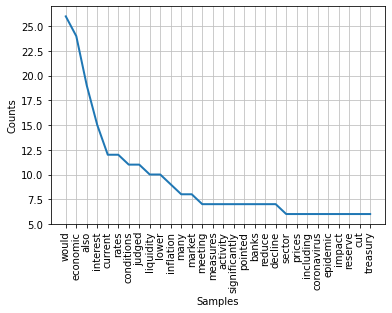

In [14]:
fdist.plot(30,cumulative=False)
plt.show()

Dla calego korpusu:

[('growth', 3636), ('economic', 2223), ('inflation', 2138), ('interest', 1483), ('pointed', 1451), ('also', 1336), ('would', 1256), ('rates', 1214), ('prices', 1093), ('economy', 917)]


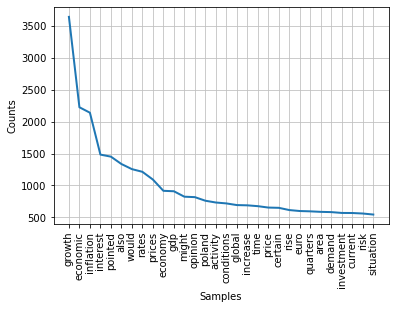

In [15]:
fdist = FreqDist(sum(minutes, []))
print(fdist.most_common(10))
fdist.plot(30,cumulative=False)
plt.show()

## 4.1 Stemizacja i lematyzacja

Proces znajdowania rdzenia słowa przez ucięcie końcówek (po odmienianych końcówek affixes). Stemming jest czasami zbyt surowy (powstają za krótkie lub niezrozumiałe słowa i odwrotny proces (stemming completion) jest wykonywany. Bardziej zaawansowany proces nazywa się lematyzacją, gdzie najpierw dokonywana jest słownikowa i morfologiczna analiza słowa, a dopiero potem usuwana jest jego odmiana.

### 4.1.1 Stemizacja - nieoptymalny kierunek

Stemming jest często robiony na gotowych, specyficznych dala języka algorytmach, np. Porter Stemming Algorithm. Są to zbiory reguł jako postępować z końcówkami słów, żeby z największą precyzją znajdować rdzenie słów. Dobre przykłady stemmingu:

* dla słów c("stems", "stemmer", "stemming", "stemmed”) rdzeniem jest stem,
* dla słów: c("fishing", "fished", and "fisher”) rdzeniem jest fish.

Złe przykłady:

* słowa: ("argue", "argued", "argues", "arguing", and "argus”) zredukowane do rdzenia argu,
* słowa: meanness and meaning zredukowane do rdzenia mean,
* słowo goose będzie zredukowane do goos a geese do gees.

Przykładowe działanie stemmerów:
<img src="img/tm4.png" width="30%">

In [16]:
porter = PorterStemmer()
stemmed = [porter.stem(word) for word in minutes[0]]
# kilka przykładowych, pierwszych z brzegu stemizowanych słów:
print(stemmed[0:20])

['decisionmak', 'meet', 'held', 'march', 'discuss', 'current', 'econom', 'situat', 'drew', 'attent', 'fact', 'global', 'econom', 'situat', 'substanti', 'deterior', 'result', 'covid', 'pandem', 'measur']


### 4.1.2 Lematyzacja - optymalny kierunek

Lematyzacja daje znacznie lepsze efekty - przyjrzyjmy się podejściom wykorzystywanym w różnych pakietach. Pełna lista pakietów oferujących lematyzatory jest tutaj:

1. WordNet
2. WordNet (with POS tag)
3. TextBlob
4. TextBlob (with POS tag)
5. spaCy
6. TreeTagger
7. Pattern
8. Gensim
9. Stanford CoreNLP

#### Pakiet NLTK

In [17]:
# Original Word ---> Root Word (lemma)      Feature

#    meeting    --->   meet                (core-word extraction)
#    was        --->    be                 (tense conversion to present tense)
#    mice       --->   mouse               (plural to singular)
  
lemmatizer = WordNetLemmatizer()
  
print("rocks :", lemmatizer.lemmatize("rocks"))
print("corpora :", lemmatizer.lemmatize("corpora"))

# próba generalna:
lemmed = [lemmatizer.lemmatize(word) for word in minutes[0]]
lemmed

rocks : rock
corpora : corpus


['decisionmaking',
 'meeting',
 'held',
 'march',
 'discussing',
 'current',
 'economic',
 'situation',
 'drew',
 'attention',
 'fact',
 'global',
 'economic',
 'situation',
 'substantially',
 'deteriorated',
 'result',
 'covid',
 'pandemic',
 'measure',
 'taken',
 'numerous',
 'country',
 'contain',
 'spread',
 'particular',
 'economic',
 'activity',
 'service',
 'sector',
 'slowed',
 'significantly',
 'consumer',
 'sentiment',
 'deteriorated',
 'many',
 'company',
 'worldwide',
 'temporarily',
 'halted',
 'production',
 'condition',
 'uncertainty',
 'outlook',
 'global',
 'gdp',
 'growth',
 'risen',
 'sharply',
 'financial',
 'market',
 'sentiment',
 'deteriorated',
 'significantly',
 'price',
 'many',
 'commodity',
 'including',
 'oil',
 'plummeted',
 'along',
 'depreciation',
 'emerging',
 'market',
 'economy',
 'currency',
 'pointed',
 'although',
 'according',
 'official',
 'data',
 'china',
 'spread',
 'coronavirus',
 'epidemic',
 'slowed',
 'following',
 'this',
 'activity',
 '

#### Pakiet NLTK z POS-tagging

Czasami dokładniejsza lematyzacja zostanie wykonana jeśli rozpoznamy części mowy.

In [18]:
lemmatizer = WordNetLemmatizer()
 
# Define function to lemmatize each word with its POS tag
 
# POS_TAGGER_FUNCTION : TYPE 1
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None

sentence = 'the cat is sitting with the bats on the striped mat under many badly flying geese'
 
# Tagging:
pos_tagged = nltk.pos_tag(nltk.word_tokenize(sentence)) 
print(pos_tagged)

[('the', 'DT'), ('cat', 'NN'), ('is', 'VBZ'), ('sitting', 'VBG'), ('with', 'IN'), ('the', 'DT'), ('bats', 'NNS'), ('on', 'IN'), ('the', 'DT'), ('striped', 'JJ'), ('mat', 'NN'), ('under', 'IN'), ('many', 'JJ'), ('badly', 'RB'), ('flying', 'VBG'), ('geese', 'JJ')]


In [19]:
# As you may have noticed, the above pos tags are a little confusing.
 
# we use our own pos_tagger function to make things simpler to understand.
wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))
print(wordnet_tagged)
#>[('the', None), ('cat', 'n'), ('is', 'v'), ('sitting', 'v'), ('with', None),
# ('the', None), ('bats', 'n'), ('on', None), ('the', None), ('striped', 'a'),
# ('mat', 'n'), ('under', None), ('many', 'a'), ('flying', 'v'), ('geese', 'a')]

[('the', None), ('cat', 'n'), ('is', 'v'), ('sitting', 'v'), ('with', None), ('the', None), ('bats', 'n'), ('on', None), ('the', None), ('striped', 'a'), ('mat', 'n'), ('under', None), ('many', 'a'), ('badly', 'r'), ('flying', 'v'), ('geese', 'a')]


In [20]:
lemmatized_sentence = [word if tag is None else lemmatizer.lemmatize(word, tag) for word, tag in wordnet_tagged]
print(lemmatized_sentence)
#> the cat can be sit with the bat on the striped mat under many fly geese

['the', 'cat', 'be', 'sit', 'with', 'the', 'bat', 'on', 'the', 'striped', 'mat', 'under', 'many', 'badly', 'fly', 'geese']


In [21]:
pos_tagged = nltk.pos_tag(nltk.word_tokenize(' '.join(minutes[0]))) 
wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))
lemmed = [lemmatizer.lemmatize(word) for word in minutes[0]]
lemmed

['decisionmaking',
 'meeting',
 'held',
 'march',
 'discussing',
 'current',
 'economic',
 'situation',
 'drew',
 'attention',
 'fact',
 'global',
 'economic',
 'situation',
 'substantially',
 'deteriorated',
 'result',
 'covid',
 'pandemic',
 'measure',
 'taken',
 'numerous',
 'country',
 'contain',
 'spread',
 'particular',
 'economic',
 'activity',
 'service',
 'sector',
 'slowed',
 'significantly',
 'consumer',
 'sentiment',
 'deteriorated',
 'many',
 'company',
 'worldwide',
 'temporarily',
 'halted',
 'production',
 'condition',
 'uncertainty',
 'outlook',
 'global',
 'gdp',
 'growth',
 'risen',
 'sharply',
 'financial',
 'market',
 'sentiment',
 'deteriorated',
 'significantly',
 'price',
 'many',
 'commodity',
 'including',
 'oil',
 'plummeted',
 'along',
 'depreciation',
 'emerging',
 'market',
 'economy',
 'currency',
 'pointed',
 'although',
 'according',
 'official',
 'data',
 'china',
 'spread',
 'coronavirus',
 'epidemic',
 'slowed',
 'following',
 'this',
 'activity',
 '

#### Pakiet TextBlom

In [22]:
s = TextBlob(' '.join(minutes[0]))
[w.lemmatize() for w in s.words]

['decisionmaking',
 'meeting',
 'held',
 'march',
 'discussing',
 'current',
 'economic',
 'situation',
 'drew',
 'attention',
 'fact',
 'global',
 'economic',
 'situation',
 'substantially',
 'deteriorated',
 'result',
 'covid',
 'pandemic',
 'measure',
 'taken',
 'numerous',
 'country',
 'contain',
 'spread',
 'particular',
 'economic',
 'activity',
 'service',
 'sector',
 'slowed',
 'significantly',
 'consumer',
 'sentiment',
 'deteriorated',
 'many',
 'company',
 'worldwide',
 'temporarily',
 'halted',
 'production',
 'condition',
 'uncertainty',
 'outlook',
 'global',
 'gdp',
 'growth',
 'risen',
 'sharply',
 'financial',
 'market',
 'sentiment',
 'deteriorated',
 'significantly',
 'price',
 'many',
 'commodity',
 'including',
 'oil',
 'plummeted',
 'along',
 'depreciation',
 'emerging',
 'market',
 'economy',
 'currency',
 'pointed',
 'although',
 'according',
 'official',
 'data',
 'china',
 'spread',
 'coronavirus',
 'epidemic',
 'slowed',
 'following',
 'this',
 'activity',
 '

#### Pakiet Spacy

In [23]:
doc = sp(' '.join(minutes[0]))
lemmed = [token.lemma_ for token in doc]
lemmed

['decisionmake',
 'meeting',
 'hold',
 'march',
 'discuss',
 'current',
 'economic',
 'situation',
 'draw',
 'attention',
 'fact',
 'global',
 'economic',
 'situation',
 'substantially',
 'deteriorate',
 'result',
 'covid',
 'pandemic',
 'measure',
 'take',
 'numerous',
 'country',
 'contain',
 'spread',
 'particular',
 'economic',
 'activity',
 'service',
 'sector',
 'slow',
 'significantly',
 'consumer',
 'sentiment',
 'deteriorate',
 'many',
 'company',
 'worldwide',
 'temporarily',
 'halt',
 'production',
 'condition',
 'uncertainty',
 'outlook',
 'global',
 'gdp',
 'growth',
 'rise',
 'sharply',
 'financial',
 'market',
 'sentiment',
 'deteriorate',
 'significantly',
 'price',
 'many',
 'commodity',
 'include',
 'oil',
 'plummet',
 'along',
 'depreciation',
 'emerge',
 'market',
 'economy',
 'currency',
 'point',
 'although',
 'accord',
 'official',
 'datum',
 'china',
 'spread',
 'coronavirus',
 'epidemic',
 'slow',
 'follow',
 'this',
 'activity',
 'chinese',
 'economy',
 'gradu

Mamy zwycięzcę. Wykonujemy działanie na wszystkich plikach:

In [24]:
for i, minute in enumerate(minutes):
    doc = sp(' '.join(minute))
    minutes[i] = [token.lemma_ for token in doc]

In [25]:
minutes[0]

['decisionmake',
 'meeting',
 'hold',
 'march',
 'discuss',
 'current',
 'economic',
 'situation',
 'draw',
 'attention',
 'fact',
 'global',
 'economic',
 'situation',
 'substantially',
 'deteriorate',
 'result',
 'covid',
 'pandemic',
 'measure',
 'take',
 'numerous',
 'country',
 'contain',
 'spread',
 'particular',
 'economic',
 'activity',
 'service',
 'sector',
 'slow',
 'significantly',
 'consumer',
 'sentiment',
 'deteriorate',
 'many',
 'company',
 'worldwide',
 'temporarily',
 'halt',
 'production',
 'condition',
 'uncertainty',
 'outlook',
 'global',
 'gdp',
 'growth',
 'rise',
 'sharply',
 'financial',
 'market',
 'sentiment',
 'deteriorate',
 'significantly',
 'price',
 'many',
 'commodity',
 'include',
 'oil',
 'plummet',
 'along',
 'depreciation',
 'emerge',
 'market',
 'economy',
 'currency',
 'point',
 'although',
 'accord',
 'official',
 'datum',
 'china',
 'spread',
 'coronavirus',
 'epidemic',
 'slow',
 'follow',
 'this',
 'activity',
 'chinese',
 'economy',
 'gradu

In [26]:
# Zapiszmy wyniki analizy do plików binarny:
with open('minutesClean.p', 'wb') as fp:
    pickle.dump(minutes, fp)
    
with open('minutesRaw.p', 'wb') as fp:
    pickle.dump(minutesCopy, fp)

# 5 Tworzenie Document Term Matrix

Jak już zostało wspomniane we wstępie, celem ustrukturyzowania danych tekstowych jest "wektoryzacja" tekstu, która w podejściu *bag of words* oznacza zamianę poszczególnych na wektory liczb (wierszowe bądź kolumnowe).

In [27]:
# Przygotowanie danych
df1 = pd.DataFrame([' '.join(minute) for minute in minutes], index=lista_plikow, columns=['text'])
df1.head()

,text
mi_17iii2020en.pdf,decisionmake meeting hold march discuss curren...
mi_i2010en.pdf,national bank poland warszawa witokrzyska phon...
mi_i2011en.pdf,national bank poland warszawa ul witokrzyska p...
mi_i2012en.pdf,national bank poland warszawa ul witokrzyska t...
mi_i2013en.pdf,national bank poland warszawaphone fax wwwnbpp...


In [28]:
# Wektoryzacja 
vectorizer = CountVectorizer()
doc_vec = vectorizer.fit_transform(df1['text'])

# Konwersja na df
dfCount = pd.DataFrame(doc_vec.toarray(), columns=vectorizer.get_feature_names_out(), index = df1.index)
dfCount.head()

,abandon,abate,ability,able,abolition,about,above,aboveexpectation,abovementione,abroad,...,yet,yield,young,yuan,yy,zero,zloty,zlotydenominate,ﬁlabour,ﬁundervaluationﬂ
mi_17iii2020en.pdf,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,1,1,0,0,0,0
mi_i2010en.pdf,0,0,0,1,0,0,0,0,0,6,...,1,0,0,0,0,0,6,0,0,0
mi_i2011en.pdf,0,0,1,0,0,0,0,0,0,3,...,1,0,0,0,0,0,2,0,0,0
mi_i2012en.pdf,0,0,0,0,0,0,0,0,0,4,...,0,0,0,0,0,0,3,0,0,0
mi_i2013en.pdf,0,1,0,0,0,0,0,0,0,2,...,3,0,0,0,0,1,0,0,0,0


In [29]:
# Lokalizacja dziwnego słowa na końcu korpusu
dfCount.loc[dfCount['ﬁundervaluationﬂ'].map(lambda x: x>0)]

,abandon,abate,ability,able,abolition,about,above,aboveexpectation,abovementione,abroad,...,yet,yield,young,yuan,yy,zero,zloty,zlotydenominate,ﬁlabour,ﬁundervaluationﬂ
mi_xii2011en.pdf,0,0,0,0,0,0,0,0,0,1,...,2,0,0,0,0,0,9,0,0,1


# 6 Podstawowy feature engineering w NLP

Dla danych tekstowych istnieje szereg wypróbowanych i popularnych technik inżynierii zmiennych, które należy znać (może takie pytanie paść na rozmowie kwalifikacyjnej):

1. Zmiana wag w macierzy DTM (TF, TF-IDF),
2. N-gramy obok pojedynczych słów,
3. Liczba słów, średnia długość słowa, najdłuższe słowo, etc.
4. Ograniczenie liczby zmiennych (feature selection).

## 6.1 Częstości procentowe (Term frequency) jako wagi

Używanie zwykłych częstości (w rozumieniu liczności) nie jest poprawne, ponieważ jeśli dokumenty (obserwacje) są różnej długości, to wagi w dłuższych tekstach będą wyższe - a powinny być wystandaryzowane - podstawowym narzędziem standaryzacji jest podzielenie liczności przez sumę wszystkich słów.

In [30]:
dfTf = dfCount.apply(lambda x: x/x.sum(), axis=1)
display(dfTf)

,abandon,abate,ability,able,abolition,about,above,aboveexpectation,abovementione,abroad,...,yet,yield,young,yuan,yy,zero,zloty,zlotydenominate,ﬁlabour,ﬁundervaluationﬂ
mi_17iii2020en.pdf,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.002195,0.0,0.0,0.001098,0.001098,0.000000,0.0,0.0,0.0
mi_i2010en.pdf,0.0,0.000000,0.000000,0.000949,0.0,0.0,0.0,0.0,0.0,0.005693,...,0.000949,0.000000,0.0,0.0,0.000000,0.000000,0.005693,0.0,0.0,0.0
mi_i2011en.pdf,0.0,0.000000,0.001052,0.000000,0.0,0.0,0.0,0.0,0.0,0.003155,...,0.001052,0.000000,0.0,0.0,0.000000,0.000000,0.002103,0.0,0.0,0.0
mi_i2012en.pdf,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.005305,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.003979,0.0,0.0,0.0
mi_i2013en.pdf,0.0,0.001377,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.002755,...,0.004132,0.000000,0.0,0.0,0.000000,0.001377,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mi_xii2017en.pdf,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.002890,...,0.003854,0.000000,0.0,0.0,0.000000,0.002890,0.000000,0.0,0.0,0.0
mi_xii2018en.pdf,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.002273,...,0.002273,0.000000,0.0,0.0,0.000000,0.002273,0.000000,0.0,0.0,0.0
mi_xii2019en.pdf,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.003699,...,0.001233,0.000000,0.0,0.0,0.001233,0.002466,0.000000,0.0,0.0,0.0
mi_xii2020en.pdf,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.002410,...,0.000000,0.001205,0.0,0.0,0.001205,0.001205,0.001205,0.0,0.0,0.0


## 6.2 Wagi TF-IDF 

Jeszcze nieco bardziej skomplikowanym podejściem są wagi *termFrequency-inverseDocumentFrequency*, wzór prezentujemy poniżej:

<img src="img/tm5.png" width="70%">

In [31]:
# Wektoryzacja 
vectorizer = TfidfVectorizer()
doc_vec = vectorizer.fit_transform(df1['text'])

# Konwersja na df
dfTfIdf = pd.DataFrame(doc_vec.toarray(), columns=vectorizer.get_feature_names_out(), index = df1.index)
dfTfIdf.head()

,abandon,abate,ability,able,abolition,about,above,aboveexpectation,abovementione,abroad,...,yet,yield,young,yuan,yy,zero,zloty,zlotydenominate,ﬁlabour,ﬁundervaluationﬂ
mi_17iii2020en.pdf,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.042498,0.0,0.0,0.025527,0.014838,0.000000,0.0,0.0,0.0
mi_i2010en.pdf,0.0,0.000000,0.000000,0.040347,0.0,0.0,0.0,0.0,0.0,0.065022,...,0.012592,0.000000,0.0,0.0,0.000000,0.000000,0.084984,0.0,0.0,0.0
mi_i2011en.pdf,0.0,0.000000,0.036883,0.000000,0.0,0.0,0.0,0.0,0.0,0.035415,...,0.013716,0.000000,0.0,0.0,0.000000,0.000000,0.030858,0.0,0.0,0.0
mi_i2012en.pdf,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.060040,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.058855,0.0,0.0,0.0
mi_i2013en.pdf,0.0,0.050264,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.029288,...,0.051045,0.000000,0.0,0.0,0.000000,0.021141,0.000000,0.0,0.0,0.0


In [32]:
# Initialize
vectorizer = TfidfVectorizer(ngram_range=(2, 2))
doc_vec = vectorizer.fit_transform(df1['text'])
 

# Konwersja na df
dfBigram = pd.DataFrame(doc_vec.toarray(), columns=vectorizer.get_feature_names_out(), index = df1.index)
dfBigram.head()

,abandon would,abate consumer,abate could,abate effect,abate mainly,abate slow,abate turn,ability company,ability economic,ability economy,...,zloty turn,zloty underline,zloty weaken,zloty weakened,zloty which,zloty would,zloty yet,zlotydenominate mortgage,ﬁlabour hoardingﬂ,ﬁundervaluationﬂ zloty
mi_17iii2020en.pdf,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
mi_i2010en.pdf,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
mi_i2011en.pdf,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.035354,0.000000,0.0,0.0,0.0,0.0
mi_i2012en.pdf,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.029857,0.0,0.0,0.0,0.0
mi_i2013en.pdf,0.0,0.0,0.0,0.0,0.046382,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0


## 6.3 Feature selection 

In [33]:
features = dfCount.columns.tolist()
features_short = dfCount.columns.values[dfCount.apply(lambda x: (x>0).sum(), axis=0) > 10]

In [34]:
len(features)

2761

In [35]:
len(features_short)

875

In [36]:
# Przy okazji, policzmy rzadkość obydwu macierzy
sparcity_all = 1 - dfCount[features].applymap(lambda x: x > 0).sum().sum()/dfCount[features].size
print(sparcity_all)

0.8693434816882204


In [37]:
sparcity_short = 1 - dfCount[features_short].applymap(lambda x: x > 0).sum().sum()/dfCount[features_short].size
print(sparcity_short)

0.6327226890756302


## 6.4 Feature generation

In [39]:
dfCount['nWords'] = [len(minute) for minute in minutes]
dfCount['longestWord'] = [max([len(word) for word in minute]) for minute in minutes]
dfCount['meanLenWord'] = [np.mean([len(word) for word in minute]) for minute in minutes]
dfCount.head()

,abandon,abate,ability,able,abolition,about,above,aboveexpectation,abovementione,abroad,...,yuan,yy,zero,zloty,zlotydenominate,ﬁlabour,ﬁundervaluationﬂ,nWords,longestWord,meanLenWord
mi_17iii2020en.pdf,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,911,14,6.677278
mi_i2010en.pdf,0,0,0,1,0,0,0,0,0,6,...,0,0,0,6,0,0,0,1068,15,6.700375
mi_i2011en.pdf,0,0,1,0,0,0,0,0,0,3,...,0,0,0,2,0,0,0,969,16,6.684211
mi_i2012en.pdf,0,0,0,0,0,0,0,0,0,4,...,0,0,0,3,0,0,0,755,18,6.886093
mi_i2013en.pdf,0,1,0,0,0,0,0,0,0,2,...,0,0,1,0,0,0,0,730,13,6.580822


# 7 Techniki wizualizacji danych

Istnieje wiele ciekawych technik wizualizacji danych tekstowych - najpopularniejsza to wordcloud.

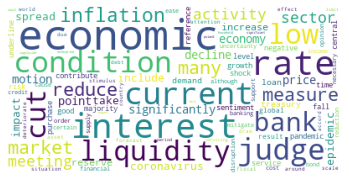

In [40]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", random_state=1, collocations=False, stopwords = STOPWORDS).generate(' '.join(minutes[0]))

plt.imshow(wordcloud) 
plt.axis("off")
plt.show()

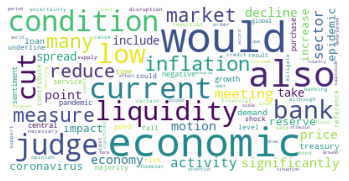

In [41]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", random_state=1, collocations=False, stopwords = ['economi', 'interest', 'rate', 'council', 'member']).generate(' '.join(minutes[0]))

plt.imshow(wordcloud) 
plt.axis("off")
plt.show()

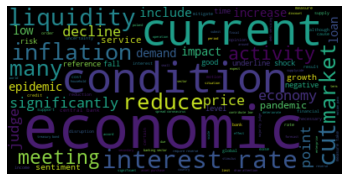

In [42]:
wordcloud = WordCloud().generate(' '.join(minutes[0]))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Z tego wyniku spróbujmy wyciągnąc dane i narysować wykres słupkowy:

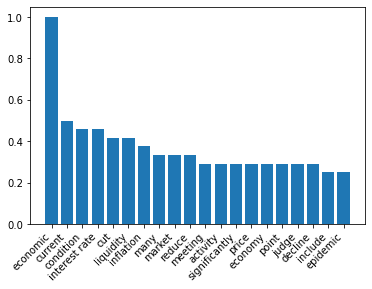

In [43]:
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

D = wordcloud.words_

# Weźmy dwadzieścia pierwszych wyrazów
n_items = take(20, D.items())
D20 = dict(n_items)

plt.bar(range(len(D20)), list(D20.values()), align='center')
plt.xticks(range(len(D20)), list(D20.keys()), rotation = 45, ha='right')


plt.show()

#### Ćwiczenie

Stwórz korpusy osobno dla każdego roku i dla każdego z nich wykonaj chmury słów (na jednym płótnie).

### Więcej informacji:

* https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a
* https://www.datacamp.com/tutorial/wordcloud-python

# 8 Inne operacje na tekstach

Oprócz bardzo zaawansowanych modeli ML z wykorzystaniem danych tekstowych jest wiele mniej złożonych operacji, które wspierają działania analityczne. 

## 8.1 Odległości pomiędzy tekstami

Odległość między dwoma tekstami definiuje się jako liczbę operacji, którą należy wykonać, aby jedno słowo zamienić w drugie. Istnieje kilka metryk, które różnią się liczbą dozwolonych operacji:

<img src="img/tm6.png" width="70%">

In [44]:
Str1 = "Back"
Str2 = "Book"
# We can convert string 1 to string 2 by 2 replacements.
lev.distance(Str1.lower(),Str2.lower())

2

## 8.2 Fuzzy Matching

*Fuzzy matching* korzysta z metryk odległości dla tekstów i pozwala na łączenie wierszy dwóch tabel z niedokładnym kluczem (adresy, nazwiska). Sami musimy jednak dopasować próg tolerancji.

In [45]:
Str1 = "Back"
Str2 = "Book"
Ratio = fuzz.ratio(Str1.lower(),Str2.lower())
print(Ratio)

50


In [46]:
# Order of the words matters
Str1 = "My name is Ali"
Str2 = "Ali is my name"
Ratio = fuzz.ratio(Str1.lower(),Str2.lower())
print(Ratio)

50


In [47]:
# The partial ratio helps us to perform substring matching. This takes the shortest string and compares it with all the substrings of the same length.
Str1 = "My name is Ali"
Str2 = "My name is Ali Abdaal"
print(fuzz.partial_ratio(Str1.lower(),Str2.lower()))

100


In [48]:
# Tokenizing, 
# getting rid of punctuation,
# lower case,
# sorting, 
# joining
# ratio computing.
Str1 = "My name is Ali"
Str2 = "Ali is my name"
print(fuzz.token_sort_ratio(Str1,Str2))

100


In [49]:
# Tokenizing, 
# getting rid of punctuation,
# lower case,
# MAKING SET
# TAKING COMMON TOKENS
# sorting, 
# joining
# ratio computing.
Str1 = "My name is Ali"
Str2 = "Ali is my name name"
print(fuzz.token_sort_ratio(Str1,Str2))
print(fuzz.token_set_ratio(Str1,Str2))

85
100


In [50]:
Str_A = 'Read the sentence - My name is Ali' 
Str_B = 'My name is Ali'
ratio = fuzz.token_set_ratio(Str_A, Str_B)
print(ratio)

100


In [51]:
# Now let's find the closest string:
query = 'My name is Ali'
choices = ['My name Ali', 'My name is Ali', 'My Ali']  
# Get a list of matches ordered by score, default limit to 5
process.extract(query, choices)

[('My name is Ali', 100), ('My name Ali', 95), ('My Ali', 86)]

In [52]:
# And THE ONE.
process.extractOne(query, choices)

('My name is Ali', 100)

In [53]:
df1 = pd.DataFrame({'Key':['Apple', 'Banana', 'Orange', 'Strawberry']})
df2 = pd.DataFrame({'Key':['Aple', 'Mango', 'Orag', 'Straw', 'Bannanna', 'Berry']})
display(df1)
display(df2)

,Key
0,Apple
1,Banana
2,Orange
3,Strawberry


,Key
0,Aple
1,Mango
2,Orag
3,Straw
4,Bannanna
5,Berry


In [54]:
# source: https://stackoverflow.com/questions/13636848/is-it-possible-to-do-fuzzy-match-merge-with-python-pandas
def fuzzy_merge(df_1, df_2, key1, key2, threshold=90, limit=2):
    """
    :param df_1: the left table to join
    :param df_2: the right table to join
    :param key1: key column of the left table
    :param key2: key column of the right table
    :param threshold: how close the matches should be to return a match, based on Levenshtein distance
    :param limit: the amount of matches that will get returned, these are sorted high to low
    :return: dataframe with boths keys and matches
    """
    s = df_2[key2].tolist()
    
    m = df_1[key1].apply(lambda x: process.extract(x, s, limit=limit))    
    df_1['matches'] = m
    
    m2 = df_1['matches'].apply(lambda x: ', '.join([i[0] for i in x if i[1] >= threshold]))
    df_1['matches'] = m2
    
    return df_1

In [55]:
df1 = pd.DataFrame({'Col1':['Microsoft', 'Google', 'Amazon', 'IBM']})
df2 = pd.DataFrame({'Col2':['Mcrsoft', 'gogle', 'Amason', 'BIM']})
display(df1)
display(df2)
fuzzy_merge(df1, df2, 'Col1', 'Col2', 80)

,Col1
0,Microsoft
1,Google
2,Amazon
3,IBM


,Col2
0,Mcrsoft
1,gogle
2,Amason
3,BIM


,Col1,matches
0,Microsoft,Mcrsoft
1,Google,gogle
2,Amazon,Amason
3,IBM,


### Więcej informacji:

* https://www.analyticsvidhya.com/blog/2021/07/fuzzy-string-matching-a-hands-on-guide/

## 8.3 Name Entity Recognition

Rozpoznawanie nazw własnych jest znanym problemem w text mining. Na szczęście w spacy dla każdeg języka znajduje się odpowiedni algorytm.

In [56]:
raw_text="The Indian Space Research Organisation or is the national space agency of India, headquartered in Bengaluru. It operates under Department of Space which is directly overseen by the Prime Minister of India while Chairman of ISRO acts as executive of DOS as well."

text1= sp(raw_text)

for word in text1.ents:
    print(word.start, word.text,word.label_)

0 The Indian Space Research Organisation ORG
12 India GPE
16 Bengaluru GPE
21 Department of Space ORG
33 India GPE
37 ISRO ORG
42 DOS ORG


In [57]:
spacy.explain("ORG")

'Companies, agencies, institutions, etc.'

In [58]:
spacy.explain("GPE")

'Countries, cities, states'

In [59]:
displacy.render(text1,style="ent",jupyter=True)

In [60]:
raw_text="I have Chevrolet Camaro. What's yours car?"

text1= sp(raw_text)

for word in text1.ents:
    print(word.start, word.text, word.label_)

2 Chevrolet Camaro ORG


## 8.4 Rozpoznawanie tekstu na obrazkach

To jest już zagadnienie bardziej z analizy obrazów/sieci neuronej niż tekstu, natomiast zamieszczamy je tutaj, ponieważ korzystanie z tej technologii jest przydatne w analizie tekstu a wiedza z sieci neuronowych ani analizy obrazów nie jest potrzebna.

In [1]:
# https://digi.bib.uni-mannheim.de/tesseract/
# conda install -c conda-forge opencv
# pip install pytesseract
import cv2
import pytesseract
from pytesseract import Output

pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

img = cv2.imread('dataTM/invoice-sample.jpg')

d = pytesseract.image_to_data(img, output_type=Output.DICT)
print(d.keys())

dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])


In [2]:
# https://stackoverflow.com/questions/22274789/cv2-imshow-function-is-opening-a-window-that-always-says-not-responding-pyth
cv2.imshow('img', img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [3]:
import re 
date_pattern = '^(0[1-9]|[12][0-9]|3[01])/(0[1-9]|1[012])/(19|20)\d\d$'

n_boxes = len(d['text'])
for i in range(n_boxes):
    if int(d['conf'][i]) > 60:
        if re.match(date_pattern, d['text'][i]):
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
            print(d['text'][i])
cv2.imshow('img', img)
cv2.waitKey(0)
cv2.destroyAllWindows()

12/12/2001


## 8.5 Poprawa literówek (spellchecking)

In [64]:
# Po angielsku
from textblob import Word

word = Word('appple')
word.correct()

'apple'

In [65]:
# Wariant I  - nie działa (nie potrafi ściągną polskiego słownika - być może trzeba je znaleźć ręcznie)
from autocorrect import Speller
spell = Speller()
spell("I'm not sleapy and tehre is no place I'm giong to.") 

spell = Speller('pl')
spell('ptaaki latatją kluczmm')

EOFError: Compressed file ended before the end-of-stream marker was reached

In [ ]:
# Wariant II (do sprawdzenia)
# http://morfeusz.sgjp.pl/
# http://download.sgjp.pl/morfeusz/Morfeusz2.pdf

In [66]:
# Wariant III. Hunspell

# Uwaga! Hunspell nie działa na Windowsie, trzeba zainstalować cyhunspell (interfejs jest ten sam)
# pip install cyhunspell
# https://pypi.org/project/cyhunspell/
from hunspell import Hunspell
h = Hunspell()

In [67]:
h.spell('appple')

False

In [68]:
h.suggest('appple')

('apple',)

In [69]:
h.stem('apples') #lematyzacja, nazwa jest myląca

('apple',)

Spróbujmy po polsku:

In [70]:
h = Hunspell('pl_PL', hunspell_data_dir='./Polski')

h.spell('poniewasz')

False

In [71]:
h.suggest('poniewasz')

('ponieważ', 'pogniewasz', 'poziewasz', 'powiewasz', 'posiewasz')

## 8.6 Lematyzacja po polsku

In [72]:
h = Hunspell('pl_PL', hunspell_data_dir='./Polski')

In [73]:
h.stem('niższy')

('niższy',)

In [74]:
[h.stem(slowo) for slowo in ['niski', 'niższy','niższych', 'niższym','niższymi']]

[('niski',), ('niższy',), ('niższy',), ('niższy',), ('niższy',)]

In [75]:
# Tymczasem w spacy...
pl = spacy.load('pl_core_news_sm')

doc = pl(' '.join(['niski', 'niższy','niższych', 'niższym','niższymi']))
[token.lemma_ for token in doc]

['niski', 'niski', 'niższych', 'niższym', 'niższymi']

## 8.7 Inne ciekawe przykłady

* https://stackabuse.com/python-for-nlp-vocabulary-and-phrase-matching-with-spacy/